### Dataset Information
UrbanSound is an audio classification dataset containing 10 classes in total, represented by real-value numbers as such:
{0: 'air_conditioner', 
1: 'car_horn', 
2: 'children_playing', 
3: 'dog_bark', 
4: 'drilling', 
5:'engine_idling',
6: 'gun_shot', 
7:'jackhammer',
 8: 'siren', 
 9: 'street_music'}

Each audio is of variable length. The training and testing datasets have 1700 and 800 audio samples respectively, with class names randomly distributed and not equally represented. Class names are mentioned in the audio file names.

The dataset indicates that there are some misclassifications in the dataset, to provide general noise which must be accounted for.

Project available at https://github.com/jasonmatthewsuhari/IT1244_UrbanSound


### Part I: Preparing Dependencies
This section goes over the external libraries that we will be using.

##### 1.1 - Installing Dependencies

In [6]:
required_libraries = [
    'scipy',
    'pandas',
    'numpy',
    'matplotlib',
    'IPython',
    'librosa',
    'soundfile',
    'tensorflow',
    'setuptools',
    'pydrive'
]

# check if the required libraries have all been installed
for library in required_libraries:
    try:
        __import__(library)
    except ImportError:
        print(f"{library} has not been installed. Installing...")
        %pip install {library}

##### 1.2 - Loading Dependencies

In [73]:
import os
from collections import Counter

from Google import Create_Service

import scipy
import pandas as pd
import numpy as np

import tensorflow as tf
import pydrive as pyd

import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa
import librosa.display

from scipy.io import wavfile as wav
import soundfile as sf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model

### Part II: Loading the Dataset
This section goes over how we load the dataset through Google Drive (tentative to change based on submission format), and also some minor debugging practices to manually check for any misclassifications.

The dataset itself is locally available, but it is best for us to read the dataset from a Google Drive for storage efficiency. For the initial setup of this notebook, we will be using the locally available data to avoid using GDrive API calls.

In [42]:
gauth = GoogleAuth()
gauth.LocalWebserverAuth()
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=806116301687-r1lsc0qbne4vhrrmojmef8tonfgjet4c.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [43]:
def read_waveform_data(file_id):
    # Assuming you have the file ID for each file
    file_obj = drive.CreateFile({'id': file_id})
    file_obj.GetContentFile('temp.wav')
    
    sample_rate, waveform_data = wav.read('temp.wav')
    return waveform_data

In [50]:
train_file_list = drive.ListFile({'q': "'178Hn4bAcib8DnlBjjCI2S_jVRD0ytktl' in parents and trashed=false"}).GetList()
train_data = [file for file in train_file_list]

test_file_list = drive.ListFile({'q': "'1IPj3qUNDgAqA0l-ErWRerpzQ2IexRJ73' in parents and trashed=false"}).GetList()
test_data = [file for file in test_file_list]

temp_data = []

for file in train_data:
    file_name = file['title']
    index = int(file_name.split('__')[0].split('_')[1:][0])
    category = file_name.split('__')[1][:-4]
    file_id = file['id']

    temp_data.append([index, file_id, category])

train_data = np.array(temp_data)

temp_data = []

for file in test_data:
    file_name = file['title']
    index = int(file_name.split('__')[0].split('_')[1:][0])
    category = file_name.split('__')[1][:-4]
    file_id = file['id']

    temp_data.append([index, file_id, category])

test_data = np.array(temp_data)

### Part III: Exploratory Data Analysis

##### Training data class_distribution

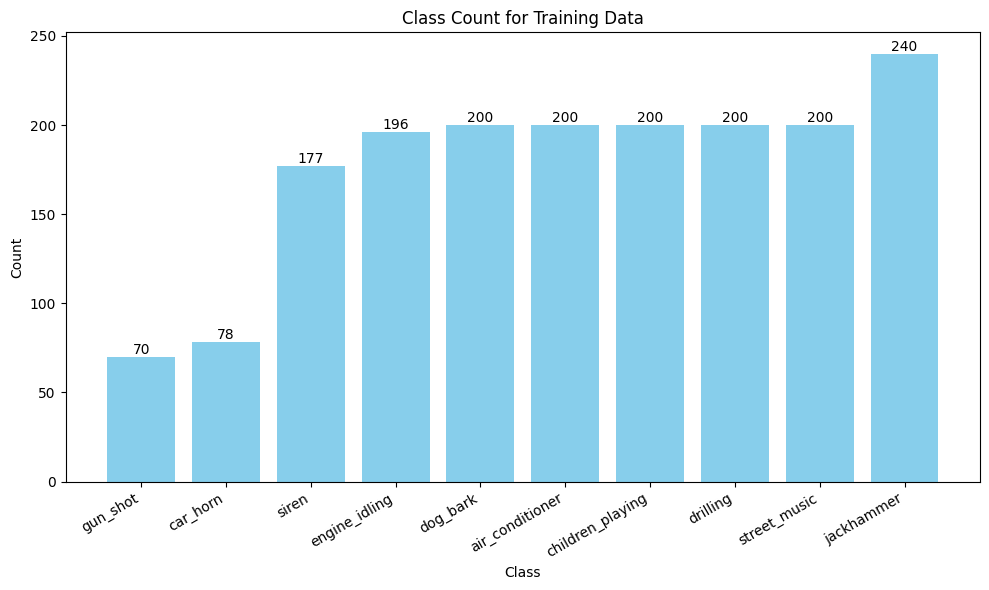

In [62]:
class_distribution = {}
for data in train_data:
    category = data[2]
    class_distribution[category] = class_distribution.get(category, 0) + 1

sorted_categories = sorted_categories = sorted(class_distribution.keys(), key=lambda category: class_distribution[category])
sorted_counts = [class_distribution[category] for category in sorted_categories]

plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_categories, sorted_counts, color='skyblue')
for bar, count in zip(bars, sorted_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count for Training Data')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

##### Waveform plots for each class

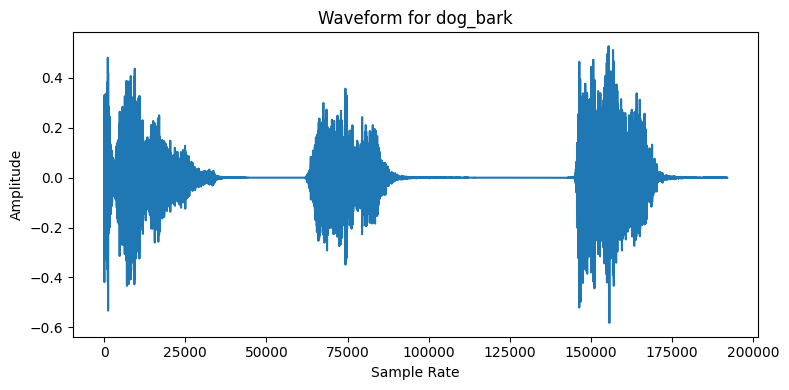

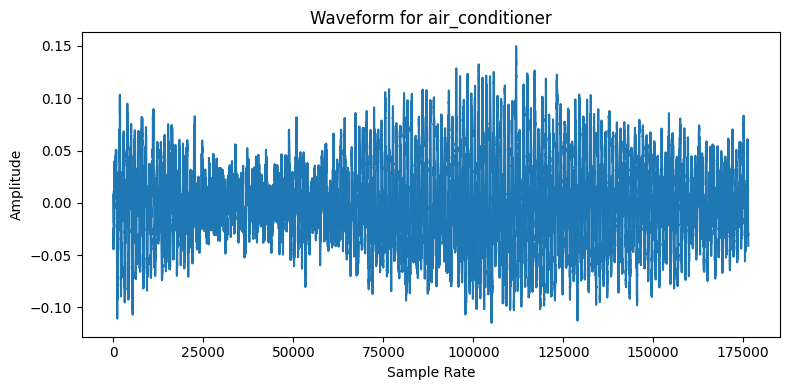

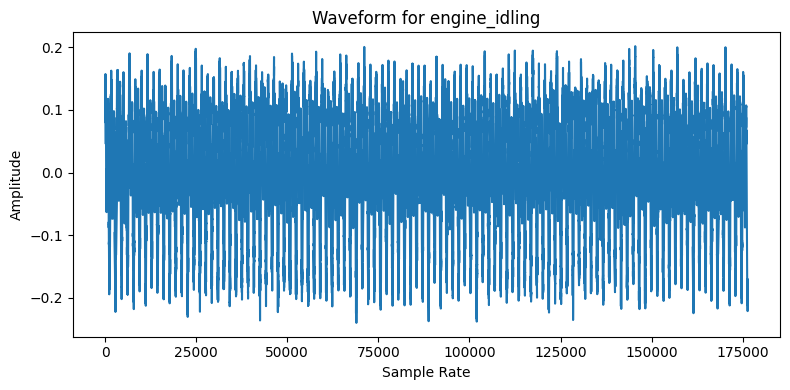

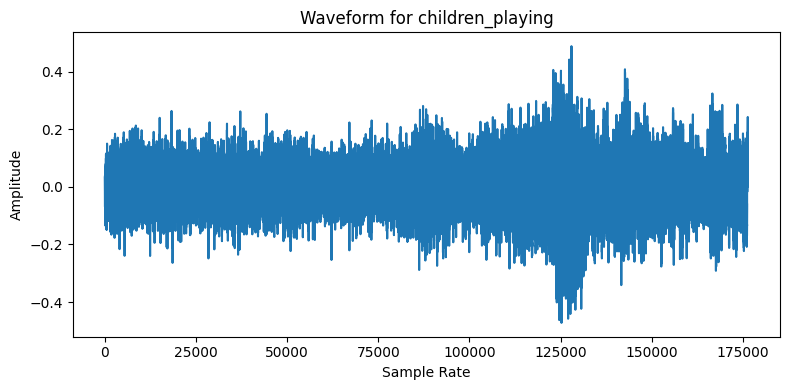

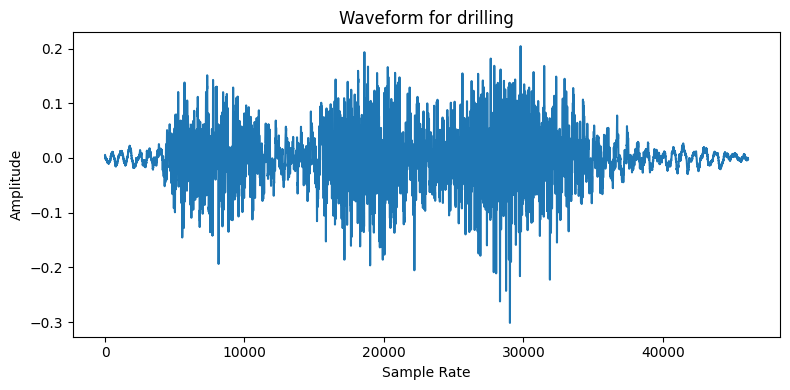

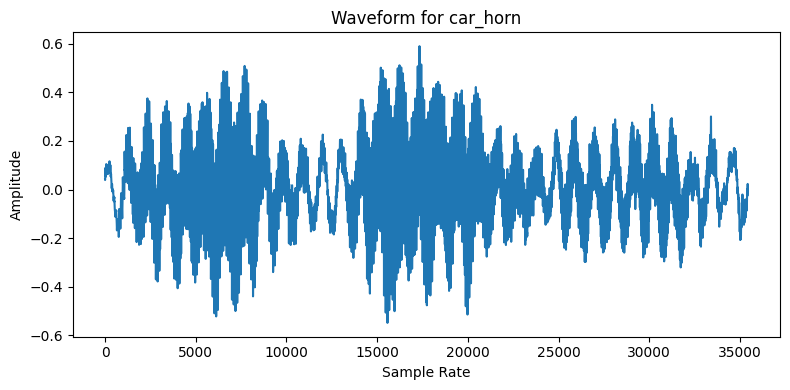

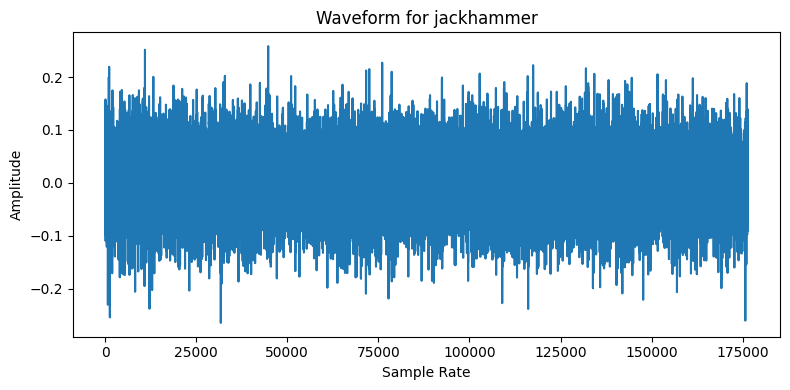

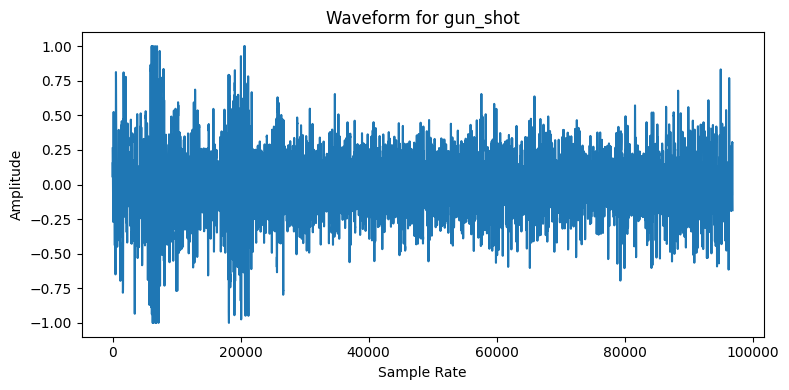

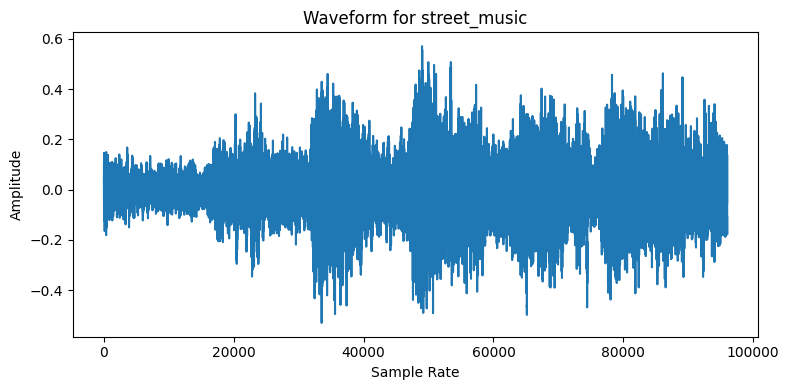

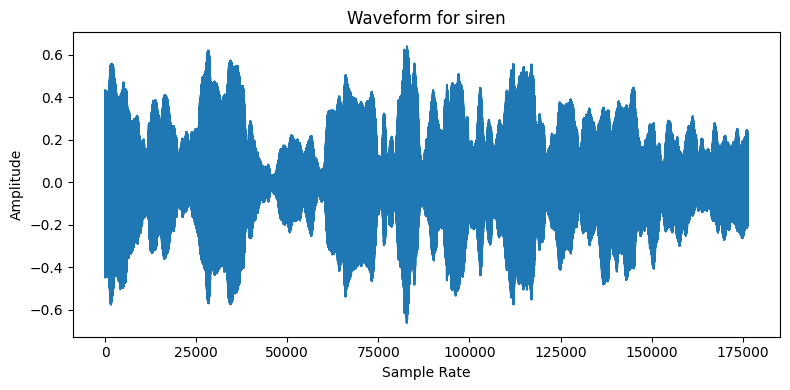

In [63]:

# Function to plot waveplot for a random audio sample in a class
def plot_waveform_for_class(class_name, files):
    plt.figure(figsize=(8, 4))
    plt.title(f'Waveform for {class_name}')
    
    # Choose a random file
    file = np.random.choice(files)
    
    # Load audio file
    audio_path = os.path.join('data/Train', file)
    waveform, sr = librosa.load(audio_path, sr=None)
    
    # Plot waveform
    plt.plot(waveform)
    plt.xlabel('Sample Rate')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Plot waveform for each class
for class_name in class_distribution.keys():
    # Get all files belonging to this class
    files = [file for file in train_data_path if class_name in file]
    # Plot waveform for this class
    plot_waveform_for_class(class_name, files)

##### Mono vs Stereo

[-5.8447593e-05  2.6010872e-05  3.4782410e-05 ...  2.2518770e-03
  2.8028022e-03  4.6307845e-03]
[[-20  14]
 [-18  16]
 [-16  19]
 ...
 [ 74 172]
 [116 185]
 [151 134]]


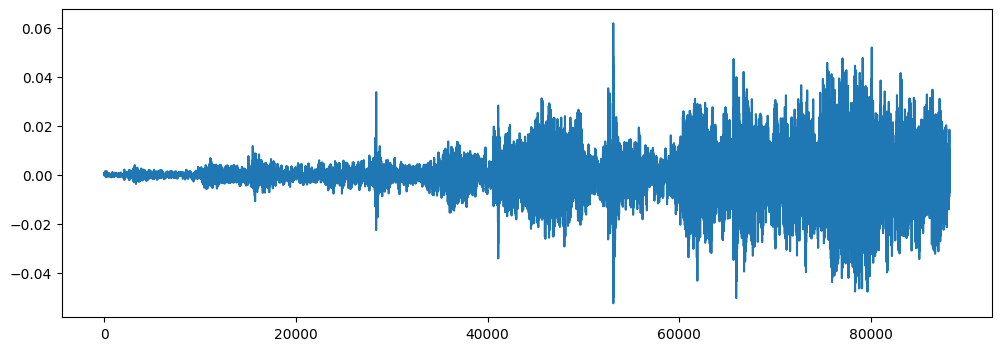

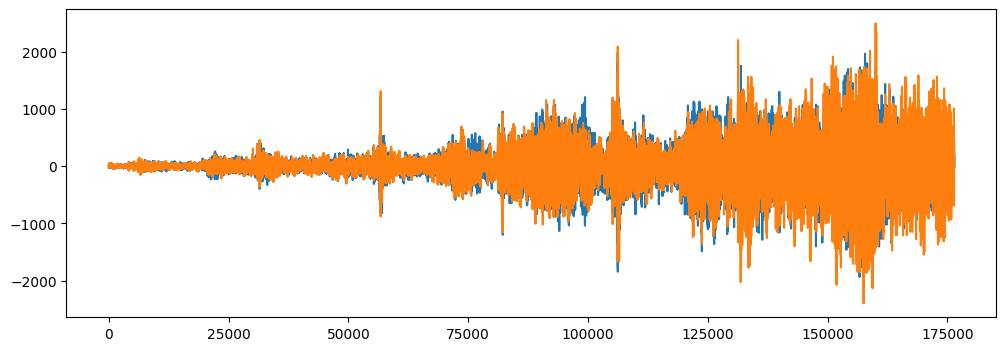

In [64]:
# Graphs for mono and stereo
audio_file_path = 'data/Train/Train_1544__street_music.wav'
librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)
print(librosa_audio_data) # mono

# Original audio with 1 channel (mono)
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

wave_sample_rate, wave_audio = wav.read(audio_file_path)
print(wave_audio) # stereo

# Original audio with 2 channels (stereo)
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

##### Plot Sound Properties of Dataset

In [65]:
# for locally stored dataset - TODO find out how to use the google drive API
def extract_properties(filepath):
    """Use sound file library to cheaply extract properties of audio file.
    
    Parameters
        filepath (str): Path of an audio file."""
    try:
        with sf.SoundFile(filepath) as f:
            properties = {
                'samplerate' : f.samplerate,
                'channels' : f.channels,
                'subtype' : f.subtype,
                'duration' : len(f) / f.samplerate
            }
        return properties
    
    except Exception as e:
        print(f"Error: {e}")
        return None
    
def scan_dataset(directory):
    """Scan a directory for audio files and extract properties of each file.
    
    Parameters
        directory (str): Path of a directory containing audio files."""
    properties = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            filepath = os.path.join(directory, file)
            file_properties = extract_properties(filepath)
            if file_properties:
                file_properties['filename'] = file
                properties.append(file_properties)
    return properties


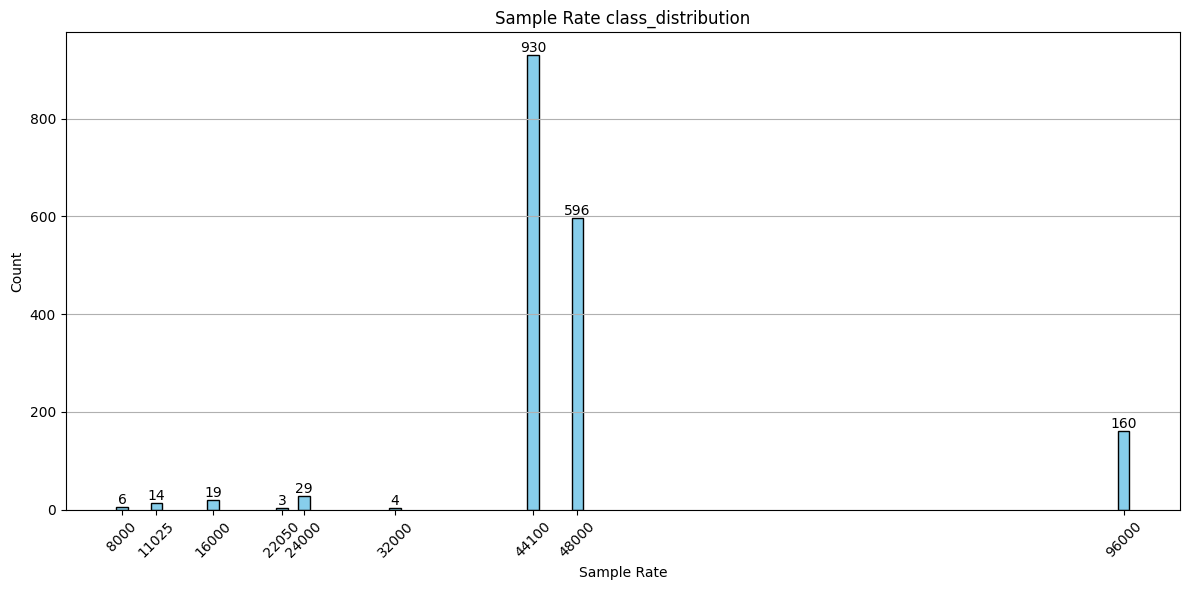

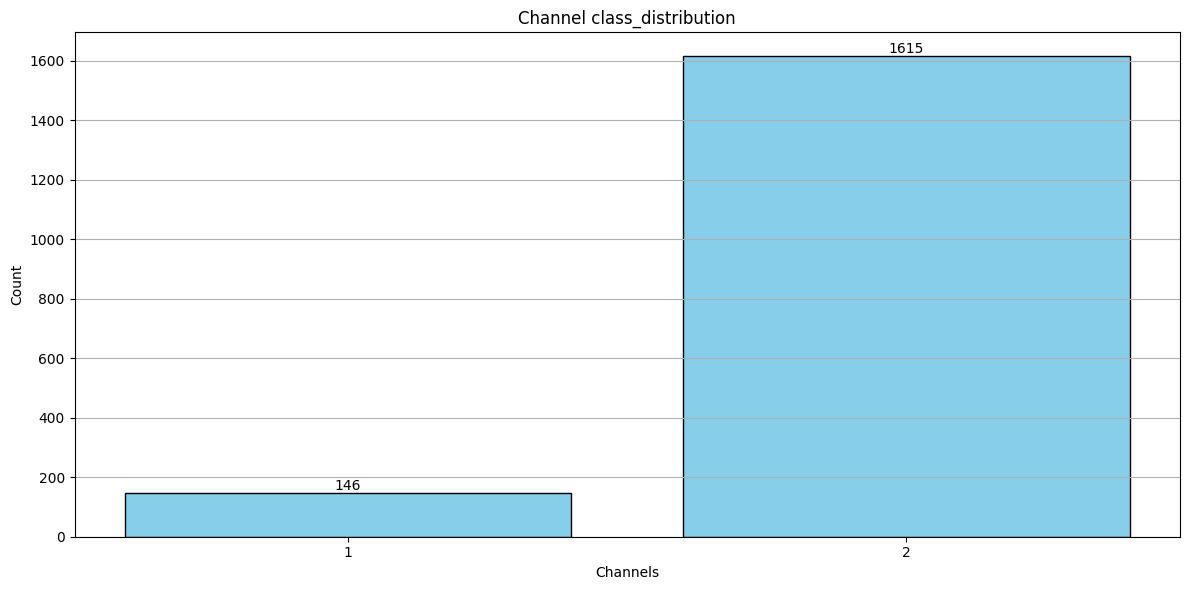

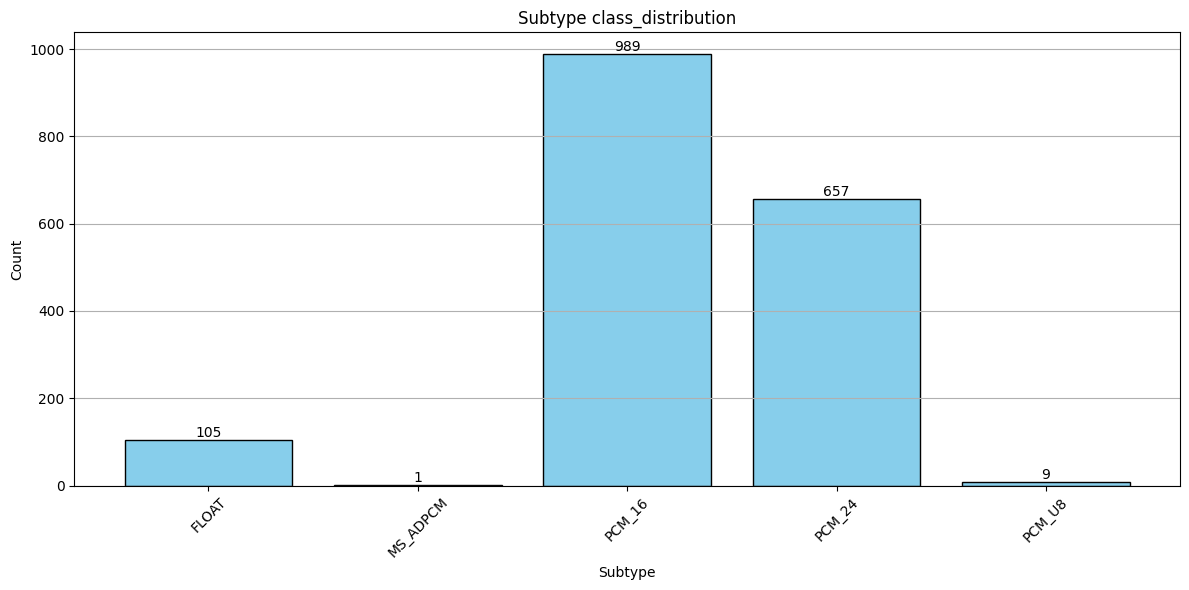

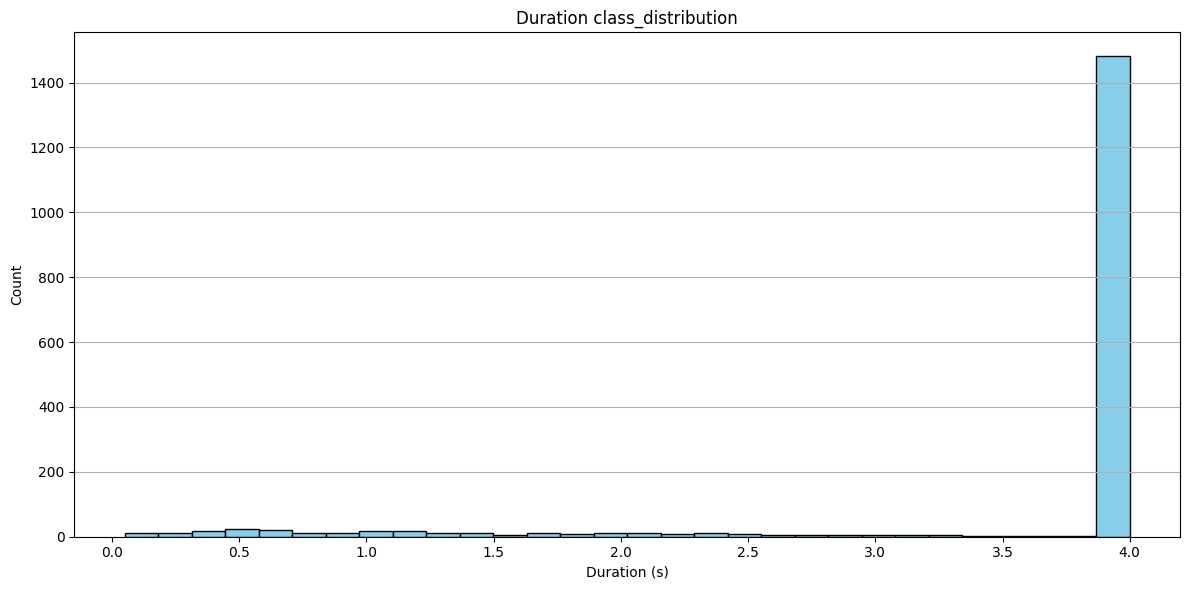

In [66]:
# Get properties of all audio files in the training dataset
train_properties = scan_dataset('data/Train')

def plot_audio_properties(property, title, xlabel, rotation=0):
    """Plot a bar graph of the chosen property.

    Parameters
        property (list): List of properties to plot.
        title (str): Title of the graph.
        xlabel (str): Label for the x-axis.
        rotation (int): Rotation of x-axis labels."""
    # Count, sort the property
    count = Counter(property)
    sorted_keys = sorted(count.keys())
    sorted_values = [count[key] for key in sorted_keys]

    # Plot the property
    plt.figure(figsize=(12, 6))
    if property == sr:
        plt.bar(sorted_keys, sorted_values, width=1000, color='skyblue', edgecolor='black')
    else:
        plt.bar(sorted_keys, sorted_values, color='skyblue', edgecolor='black')
        
    for bar, value in zip(sorted_keys, sorted_values):
        plt.text(bar, value, str(value), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    if rotation:
        plt.xticks(sorted_keys, rotation=rotation)
    else: # to get integer x-axis labels
        plt.xticks(sorted_keys)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

def plot_duration(durations):
    """Plot a histogram of the duration of audio files.
    
    Parameters
        durations (list): List of durations of audio files."""
    plt.figure(figsize=(12, 6))
    plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
    plt.title('Duration class_distribution')
    plt.xlabel('Duration (s)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# Separate properties
sr = [prop['samplerate'] for prop in train_properties]
ch = [prop['channels'] for prop in train_properties]
st = [prop['subtype'] for prop in train_properties]
duration = [prop['duration'] for prop in train_properties]

# Plot properties
plot_audio_properties(sr, 'Sample Rate class_distribution', 'Sample Rate', rotation=45)
plot_audio_properties(ch, 'Channel class_distribution', 'Channels')
plot_audio_properties(st, 'Subtype class_distribution', 'Subtype', rotation=45)
plot_duration(duration)

##### Data Preprocessing & Augmentation before feature extraction

In [67]:
def time_shift(audio, shift):
    """Shift the audio to the left or right by a random amount.

    Parameters
        audio (ndarray): Audio data.
        shift (int): Maximum shift amount."""
    if shift <= 0:
        return audio # no shift
    shift_amount = np.random.randint(-shift, shift)
    return np.roll(audio, shift_amount, axis=1) # axis=1 to shift along time axis (for stereo)

def pitch_shift(audio, sr, pitch):
    """Shift the pitch of the audio by a random amount.

    Parameters
        audio (ndarray): Audio data.
        sr (int): Sample rate of the audio.
        pitch (int): Maximum pitch shift amount."""
    if pitch <= 0:
        return audio # no shift
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=np.random.randint(-pitch, pitch))

In [68]:
def preprocess_file(filepath, sr=44100, ch=2, duration=4):
    """Preprocess an audio file by converting it to mono, resampling, and trimming/padding"""
    # note: librosa converts to PCM_32 by default
    try:
        # Load audio
        audio, sr = librosa.load(filepath, sr=sr, mono=False)

        # Normalize audio
        audio = librosa.util.normalize(audio)

        # If mono, convert to stereo
        if audio.ndim == 1:
            audio = np.repeat(audio.reshape(1, -1), ch, axis=0)

        # Data Augmentation - Time Shift and Pitch Shift
        # this part actually takes forever, considering using multiprocessing or threading
        # NOTE: try playing with the shift and pitch values
        audio = time_shift(audio, 1) # doesn't take that long
        # audio = pitch_shift(audio, sr, 1) # takes a while, around 1min+ for me

        # Pad or trim audio to 4s
        target = int(sr * duration)
        if len(audio.T) < target: # pad
            # Pad with zeros, might introduce noise, see if have better way
            padding = target - len(audio.T)
            audio = np.pad(audio, ((0, 0), (0, padding)), mode='constant')
        else: # trim
            audio = audio[:, :target]

        return audio, sr

    except Exception as e:
        print(f"Error in conversion: {e}")
        return None, None

def preprocess_dataset(directory):
    """Preprocess all audio files in a directory."""
    preprocessed_data = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            filepath = os.path.join(directory, file)
            audio, sr = preprocess_file(filepath)
            if audio is not None:
                preprocessed_data.append(audio)

    return preprocessed_data

In [69]:
# Preprocess training data 
train_data = preprocess_dataset('data/Train')

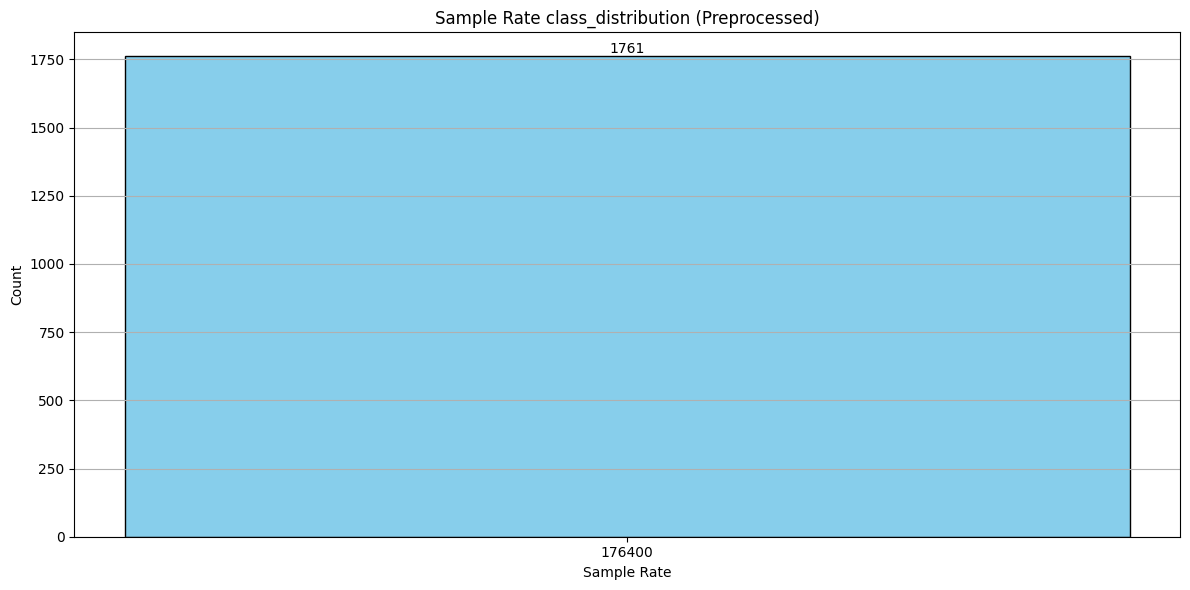

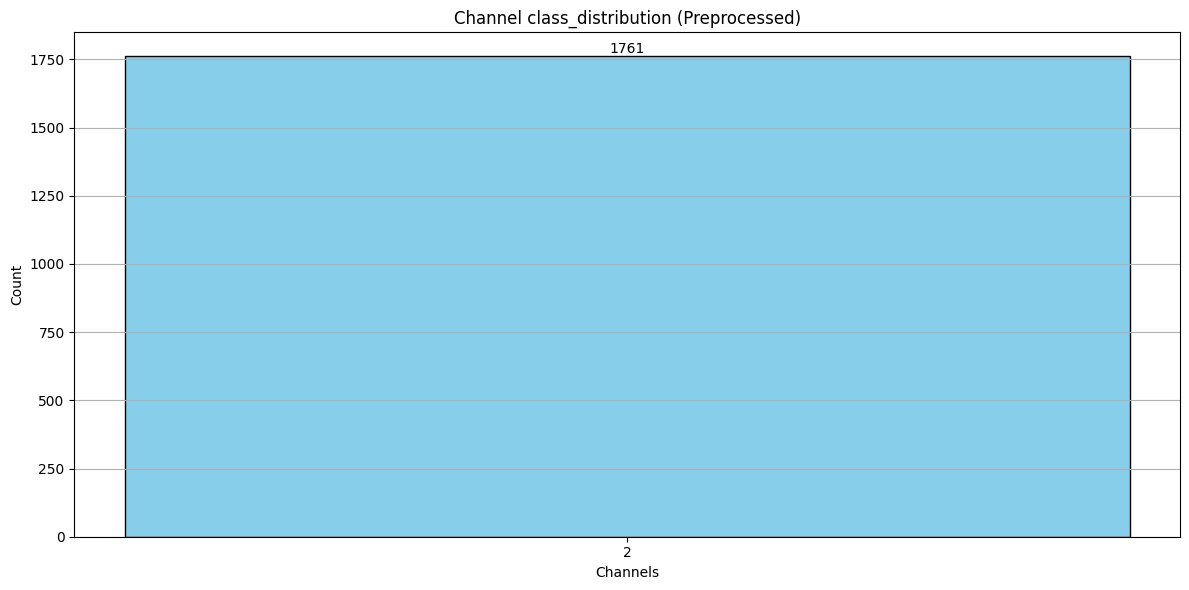

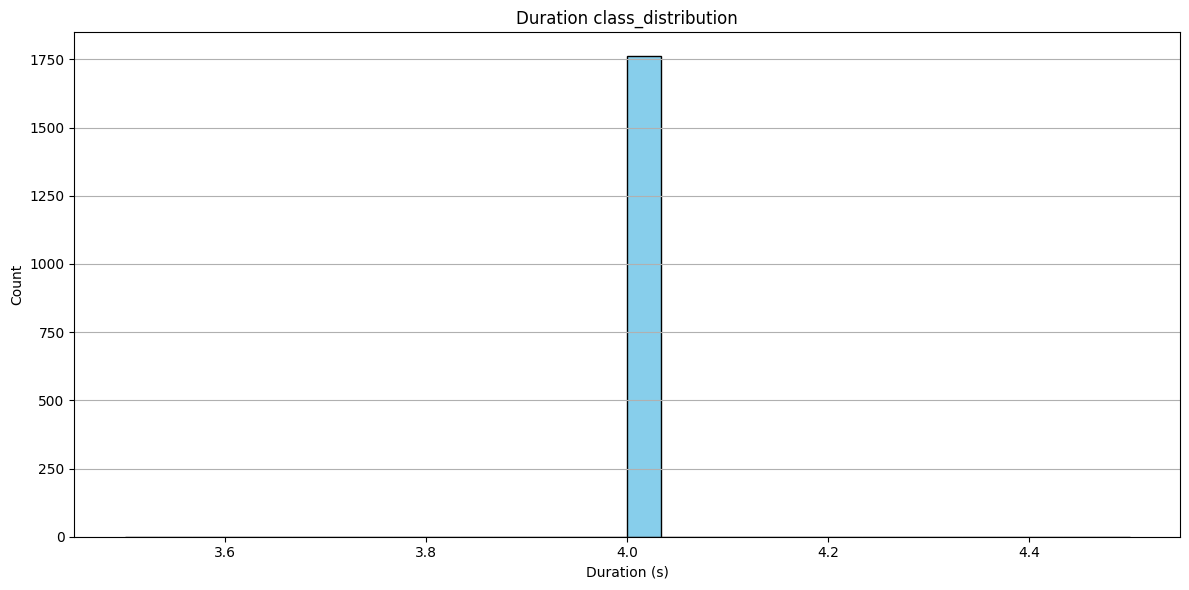

In [70]:
# plot the sr, ch, st, duration of preprocessed data (if you want to check the preprocessed data)
def plot_preprocessed_properties(data):
    """Plot properties of preprocessed audio data."""
    sr = [audio.shape[1] for audio in data]
    ch = [audio.shape[0] for audio in data]
    duration = [audio.shape[1] / 44100 for audio in data]

    plot_audio_properties(sr, 'Sample Rate class_distribution (Preprocessed)', 'Sample Rate')
    plot_audio_properties(ch, 'Channel class_distribution (Preprocessed)', 'Channels')
    plot_duration(duration)

plot_preprocessed_properties(train_data)

##### Extracting Features: Mel-Frequency Cepstral Coefficients (MFCC)

In [71]:
# MFCC for one sample file
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
mfccs

def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

# MFCC for every training file

(40, 173)


### Part IV: Audio Classification Model

In [75]:
# Step 1: Define your folder structure
data_dir = 'Train'
classes = class_distribution.keys()
#filename.split("_")[3].split(".")[0]
# Step 2: Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        #class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(data_dir):
            if filename.split("_")[3].split(".")[0] == class_name:
                file_path = os.path.join(data_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)

    return np.array(data), np.array(labels)

# Step 3: Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Step 4: Create a neural network model
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

# Step 7: Save the model
model.save('TensorAudioModel.keras')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Train'

In [74]:
model = load_model('TensorAudioModel.keras')

# Define the target shape for input spectrograms
target_shape = (128, 128)

# Define your class labels
classes = ['air', 'car','engine','street','children','dog','gun','jackhammer','siren','drilling']

# Function to preprocess and classify an audio file
def test_audio(file_path, model):
    # Load and preprocess the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    mel_spectrogram = tf.reshape(mel_spectrogram, (1,) + target_shape + (1,))

    # Make predictions
    predictions = model.predict(mel_spectrogram)

    # Get the class probabilities
    class_probabilities = predictions[0]

    # Get the predicted class index
    predicted_class_index = np.argmax(class_probabilities)

    return class_probabilities, predicted_class_index

# Test an audio file
test_audio_file = 'Test/Test_143__children_playing.wav'
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

ValueError: File not found: filepath=TensorAudioModel.keras. Please ensure the file is an accessible `.keras` zip file.

### Part V: Model Testing and Evaluation

### Part VI: Model Tuning